# How to do Unsupervised Clustering with Keras
link: https://medium.com/@chengweizhang2012/how-to-do-unsupervised-clustering-with-keras-9e1284448437

Deep learning algorithms are good at mapping input to output given labeled datasets thanks to its exceptional capability to express non-linear representations. This kind of tasks is known as classification, while someone has to label those data. Whether labeling images of XRay or topics for news reports, it depends on human intervention and can become quite costly as datasets grow larger.

Cluster analysis or clustering is one of the unsupervised machine learning technique doesn’t require labeled data. It does this by grouping datasets by their similarities.

Why should you care about clustering or cluster analysis? Let me show you some ideas.

## Applications of Clustering
 * Recommendation system, by learning the users’ purchase history, a clustering model can segment users by similarities, helping you find like-minded users or related products.
 * In biology, sequence clustering algorithms attempt to group biological sequences that are somehow related. Proteins were clustered according to their amino acid content.
 * Image or video clustering analysis to divide them groups based on similarities.
 * In a medical database, each patient may have a distinct real-valued measure for specific tests (e.g., glucose, cholesterol). Clustering patients first may help us understand how binning should be done on real-valued features to reduce feature sparsity and improve accuracy on classification tasks such as survival prediction of cancer patients.
 * General use case, generating a compact summary of data for classification, pattern discovery, hypothesis generation and testing.
 
Anyway, clustering is a valuable asset to acquire for any data scientists.
 
## What makes a Good Clustering
A good clustering method will produce high-quality clusters which should have:
 * High intra-class similarity: Cohesive within clusters
 * Low inter-class similarity: Distinctive between clusters

## Set a baseline with K-Means
The traditional K-means algorithm is fast and applicable to a wide range of problems. However, their distance metrics are limited to the original data space, and it tends to be ineffective when input dimensionality is high, for example, images.

Let’s train a K-Means model to cluster the MNIST handwritten digits to 10 clusters.

In [1]:
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
# 10 clusters
n_clusters = len(np.unique(y))

In [ ]:
# Runs in parallel 4 CPUs
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
# Train K-Means.
y_pred_kmeans = kmeans.fit_predict(x)

In [ ]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score


def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from sklearn.utils.linear_assignment_ import linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size
# Evaluate the K-Means clustering accuracy.

In [ ]:
acc(y, y_pred_kmeans)

0.5323571428571429

The evaluated K-Means clustering accuracy is 53.2%, we will compare it with our deep embedding clustering model later.
The model we are going to introduce shortly constitutes several parts:
 * An autoencoder, pre-trained to learn the initial condensed representation of the unlabeled datasets.
 * A clustering layer stacked on the encoder to assign encoder output to a cluster. The clustering layer’s weights are initialized with K-Means’ cluster centers based on the current assessment.
 * Train the clustering model to refine the clustering layer and encoder jointly.

## Pre-train autoencoder
Autoencoder is a data compression algorithm where there are two major parts, encoder, and decoder. The encoder’s job is to compress the input data to lower dimensional features. For example, one sample of the 28x28 MNIST image has 784 pixels in total, the encoder we built can compress it to an array with only ten floating point numbers also known as the features of an image. The decoder part, on the other hand, takes the compressed features as input and reconstruct an image as close to the original image as possible. Autoencoder is unsupervised learning algorithm in nature since during training it takes only the images themselves and not need labels.
![image](Images/2019_3_29_1.jpg)
The autoencoder we build is one fully connected symmetric model, symmetric on how an image is compressed and decompressed by exact opposite manners.
![image](Images/2019_3_29_2.png)
We are going to train the autoencoder for 300 epochs and save the model weights for later.

In [2]:
import numpy as np
np.random.seed(10)
from time import time
import numpy as np
import tensorflow.keras.backend as K
# from tensorflow.keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import callbacks
from tensorflow.keras.initializers import VarianceScaling
from sklearn.cluster import KMeans

In [3]:
#model define
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [4]:
dims = [x.shape[-1], 500, 500, 2000, 100]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = SGD(lr=1, momentum=0.9)
pretrain_epochs = 300
batch_size = 256
save_dir = './data'

In [5]:
autoencoder, encoder = autoencoder(dims, init=init)

In [7]:
# coding=utf-8
'''
@author: admin
'''
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import plot_model

import pydot

model = Sequential()
model.add(Dense(32, activation='relu', input_dim=100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Generate dummy data
import numpy as np
data = np.random.random((1000, 100))
labels = np.random.randint(2, size=(1000, 1))
plot_model(model, to_file='model.png',show_shapes=True)
# Train the model, iterating on the data in batches of 32 samples
# model.fit(data, labels, epochs=10, batch_size=32)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [ ]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + '/ae_weights.h5')

Epoch 1/300
55296/70000 [======================>.......] - ETA: 6s - loss: 0.0681

In [85]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
print(x.shape)
y_pred = kmeans.fit_predict(encoder.predict(x_test))
print(acc(y_test, y_pred))

(70000, 784)


ValueError: Error when checking input: expected input to have 2 dimensions, but got array with shape (10000, 28, 28)

## Clustering model
By training the autoencoder, we have its encoder part learned to compress each image into ten floating point values. You may be thinking, since the input dimensionality is reduced to 10, K-Means should be able to do the clustering from here? Yes, we are going to use K-Means to generate the cluster centroids, which is the 10 clusters’ centers in the 10-D feature space. But we are also going to build our custom clustering layer to convert input features to cluster label probability.

The probability is calculated by student’s t-distribution. T-distribution, as same as used in the t-SNE algorithm, measure the similarity between an embedded point and a centroid. And as you might guess the clustering layer acts similar to K-means for clustering, and the layer’s weights represent the cluster centroids which can be initialized by training a K-means.

If you are new to build custom layer in Keras, there are three mandatory methods you will implement.

* build(input_shape), where you define the layer's weights, in our case the 10 clusters in 10-D feature space, that is 10x10 weight variables.
* call(x), where the layer logic lives, that is where the mapping from the features to clustering labels' magic happens.
* compute_output_shape(input_shape), specify here the shape transformation logic from input to output shapes.
Here is the custom clustering layer code,

In [12]:
import tensorflow as tf

In [54]:
class ClusteringLayer(tf.keras.layers.Layer):
    """
    Clustering layer converts input sample (feature) to soft label.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = tf.keras.layers.InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = int(input_shape[1])
        self.input_spec = tf.keras.layers.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(name="clusters",shape=(self.n_clusters, input_dim), initializer='glorot_uniform')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True
        

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.        
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [74]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)
# Initialize cluster centers using k-means.
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

<class 'int'>
<class 'int'>
0.8711714285714286


![image](Images/2019_3_29_3.png)

## Training the clustering model
### Auxiliary target distribution and KL divergence loss
The next step is to improve the clustering assignment and feature representation simultaneously. For this purpose, we will define a centroid-based target probability distribution and minimize its KL divergence against the model clustering result.

We would like to have the target distribution to have the following properties.

* Strengthen predictions, i.e., improve cluster purity.
* Put more emphasis on data points assigned with high confidence.
* Prevent large clusters from distorting the hidden feature space.

The target distribution is computed by first raising q (the encoded feature vectors) to the second power and then normalizing by frequency per cluster.

In [78]:
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

It is necessary to iteratively refine the clusters by learning from the high confidence assignments with the help of the auxiliary target distribution. After a specific number of iteration, the target distribution is updated, and the clustering model will be trained to minimize the KL divergence loss between the target distribution and the clustering output. The training strategy can be seen as a form of self-training. As in self-training, we take an initial classifier and an unlabeled dataset, then label the dataset with the classifier to train on its high confidence predictions.

The loss function, KL divergence or Kullback–Leibler divergence it is a measure of behavior difference between two different distributions. We want to minimize it so that the target distribution is as close to the clustering output distribution as possible.

In the following code snippet, the target distribution updates every 140 training iteration.

In [76]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')

maxiter = 8000
update_interval = 140
index = 0
index_array = np.arange(x.shape[0])
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p
        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            myacc = np.round(acc(y, y_pred), 5)

    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

You will see the clustering accuracy steadily increasing after each update.

## Evaluation metric
The metric says it has reached 96.2% clustering accuracy, which is quite good considering that the inputs are unlabeled images. Let’s take a closer look at how the accuracy it is derived.

This metric takes a cluster assignment from an unsupervised algorithm and a ground truth assignment and then finds the best matching between them.

The best mapping can be efficiently computed by the Hungarian algorithm which is implemented in scikit learn library as linear_assignment.

In [79]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)
acc = sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [80]:
acc

0.8706571428571429

It is more straightforward to look at the confusion matrix.

Here you can quickly match the clustering assignment by hand, e.g., cluster 1 matches with true label 7 or handwritten digit “7” and vise visa.

The confusion matrix plotting code snippet shown below.

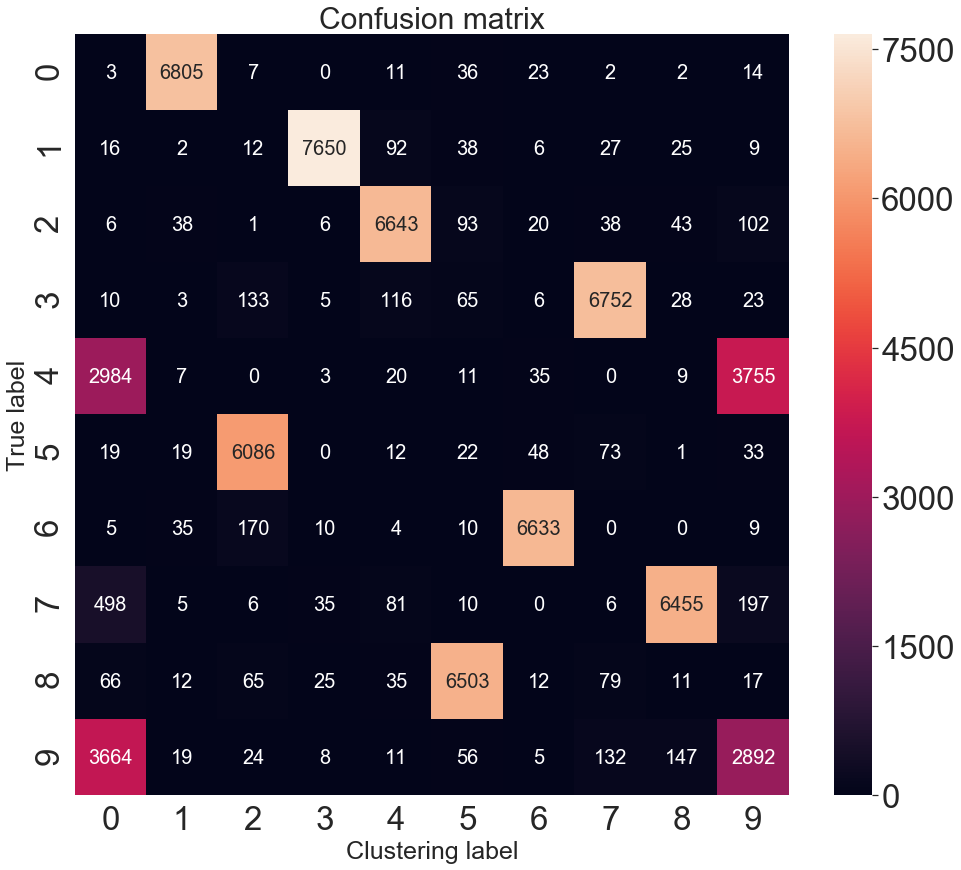

In [81]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()